In [1]:
import pygit2
import os
from getpass import getpass

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

%matplotlib inline
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from itertools import product
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

from pygit2_tools import RemoteCallbacks, pull

In [3]:
# GitHub passphrase
PASS = getpass('passphrase: ')
RC = RemoteCallbacks(PASS)

passphrase: ········


In [4]:
%%time

LOCAL_REPO_OWID = 'covid-19-data'

if not os.path.exists(LOCAL_REPO_OWID):
    print('cloning...')
    local_repo_owid = pygit2.clone_repository('ssh://github.com/owid/covid-19-data', LOCAL_REPO_OWID, callbacks=RC)
else:
    print('pulling...')
    local_repo_owid = pygit2.Repository(os.path.abspath('./%s/.git/' % LOCAL_REPO_OWID))
    pull(local_repo_owid, callbacks=RC)

pulling...
CPU times: user 16.4 s, sys: 2.43 s, total: 18.8 s
Wall time: 37.8 s


In [5]:
%%time

LOCAL_REPO_JHU = 'covid-19-data-jhu'

if not os.path.exists(LOCAL_REPO_JHU):
    print('cloning...')
    local_repo_jhu = pygit2.clone_repository('ssh://github.com/CSSEGISandData/COVID-19', LOCAL_REPO_JHU, callbacks=RC)
else:
    print('pulling...')
    local_repo_jhu = pygit2.Repository(os.path.abspath('./%s/.git/' % LOCAL_REPO_JHU))
    pull(local_repo_jhu, callbacks=RC)

pulling...
CPU times: user 1.11 s, sys: 114 ms, total: 1.23 s
Wall time: 3.61 s


In [6]:
dt0 = pd.read_excel('covid-19-data/public/data/owid-covid-data.xlsx')
print(dt0.shape)
dt0

(20766, 32)


iso_code       location        date  total_cases  new_cases  \
0          ABW          Aruba  2020-03-13            2          2   
1          ABW          Aruba  2020-03-20            4          2   
2          ABW          Aruba  2020-03-24           12          8   
3          ABW          Aruba  2020-03-25           17          5   
4          ABW          Aruba  2020-03-26           19          2   
...        ...            ...         ...          ...        ...   
20761      NaN  International  2020-02-28          705          0   
20762      NaN  International  2020-02-29          705          0   
20763      NaN  International  2020-03-01          705          0   
20764      NaN  International  2020-03-02          705          0   
20765      NaN  International  2020-03-10          696         -9   

       total_deaths  new_deaths  total_cases_per_million  \
0                 0           0                   18.733   
1                 0           0                   37.465   
2                 0           0                  112.395   
3                 0           0                  159.227   
4                 0           0                  177.959   
...             ...         ...                      ...   
20761             4           0                      NaN   
20762             6           2                      NaN   
20763             6           0                      NaN   
20764             6           0                      NaN   
20765             7           1                      NaN   

       new_cases_per_million  total_deaths_per_million  ...  aged_65_older  \
0                     18.733                       0.0  ...         13.085   
1                     18.733                       0.0  ...         13.085   
2                     74.930                       0.0  ...         13.085   
3                     46.831                       0.0  ...         13.085   
4                     18.733                       0.0  ...         13.085   
...                      ...                       ...  ...            ...   
20761                    NaN                       NaN  ...            NaN   
20762                    NaN                       NaN  ...            NaN   
20763                    NaN                       NaN  ...            NaN   
20764                    NaN                       NaN  ...            NaN   
20765                    NaN                       NaN  ...            NaN   

       aged_70_older  gdp_per_capita  extreme_poverty  cvd_death_rate  \
0              7.452       35973.781              NaN             NaN   
1              7.452       35973.781              NaN             NaN   
2              7.452       35973.781              NaN             NaN   
3              7.452       35973.781              NaN             NaN   
4              7.452       35973.781              NaN             NaN   
...              ...             ...              ...             ...   
20761            NaN             NaN              NaN             NaN   
20762            NaN             NaN              NaN             NaN   
20763            NaN             NaN              NaN             NaN   
20764            NaN             NaN              NaN             NaN   
20765            NaN             NaN              NaN             NaN   

       diabetes_prevalence  female_smokers male_smokers  \
0                    11.62             NaN          NaN   
1                    11.62             NaN          NaN   
2                    11.62             NaN          NaN   
3                    11.62             NaN          NaN   
4                    11.62             NaN          NaN   
...                    ...             ...          ...   
20761                  NaN             NaN          NaN   
20762                  NaN             NaN          NaN   
20763                  NaN             NaN          NaN   
20764                  NaN             NaN          

In [7]:
dt0['date'] = dt0['date'].astype(np.datetime64)
dt0['date'] = dt0['date'] + pd.Timedelta(-1, unit='D')

In [8]:
dt_jhu_rec = pd.read_csv('covid-19-data-jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')\
    .rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'})

# dt_jhu_loc = pd.read_csv('covid-19-data-jhu/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv')
# dt_jhu_loc = dt_jhu_loc[['Country_Region', 'Province_State', 'iso3']].drop_duplicates()

# dt_jhu_rec = dt_jhu_rec.merge(dt_jhu_loc, on=['Country_Region', 'Province_State'], how='left')\
#     .rename(columns={'iso3': 'iso_code', 'Country_Region': 'location'})

loc_map = dict(pd.read_csv('locations_mapping.csv').values)
dt_jhu_rec['Country_Region'].replace(loc_map, inplace=True)
dt_jhu_rec = dt_jhu_rec.rename(columns={'Country_Region': 'location'}).drop(['Lat', 'Long'], axis=1)

cols_header = ['Province_State', 'location']
cols_ts = [c for c in dt_jhu_rec.columns if not c in cols_header]

dt_jhu_rec_total = dt_jhu_rec[cols_header + cols_ts]
dt_jhu_rec_total

Province_State               location  1/22/20  1/23/20  1/24/20  1/25/20  \
0              NaN            Afghanistan        0        0        0        0   
1              NaN                Albania        0        0        0        0   
2              NaN                Algeria        0        0        0        0   
3              NaN                Andorra        0        0        0        0   
4              NaN                 Angola        0        0        0        0   
..             ...                    ...      ...      ...      ...      ...   
248            NaN  Sao Tome and Principe        0        0        0        0   
249            NaN                  Yemen        0        0        0        0   
250            NaN                Comoros        0        0        0        0   
251            NaN             Tajikistan        0        0        0        0   
252            NaN                Lesotho        0        0        0        0   

     1/26/20  1/27/20  1/28/20  1/29/20  ...  5/20/20  5/21/20  5/22/20  \
0          0        0        0        0  ...      930      938      996   
1          0        0        0        0  ...      758      771      777   
2          0        0        0        0  ...     3968     4062     4256   
3          0        0        0        0  ...      639      639      652   
4          0        0        0        0  ...       17       17       17   
..       ...      ...      ...      ...  ...      ...      ...      ...   
248        0        0        0        0  ...        4        4        4   
249        0        0        0        0  ...        5        5       11   
250        0        0        0        0  ...        8        8       18   
251        0        0        0        0  ...      470      470     1089   
252        0        0        0        0  ...        0        0        0   

     5/23/20  5/24/20  5/25/20  5/26/20  5/27/20  5/28/20  5/29/20  
0       1040     1075     1097     1128     1138     1209     1259  
1        783      789      795      803      812      823      851  
2       4426     4784     4747     4918     5129     5277     5422  
3        653      653      663      676      676      681      684  
4         18       18       18       18       18       18       18  
..       ...      ...      ...      ...      ...      ...      ...  
248        4        4        4       68       68       68       68  
249       11       10       10       10       10       11       11  
250       18       21       21       21       24       24       24  
251     1223     1301     1395     1417     1575     1674     1769  
252        0        0        0        0        0        1        1  

[253 rows x 131 columns]

In [9]:
dt_jhu_rec_lead = dt_jhu_rec_total[cols_ts[1:]]
dt_jhu_rec_lag = dt_jhu_rec_total[cols_ts[:-1]]
dt_jhu_rec_lag.columns = dt_jhu_rec_lead.columns

dt_jhu_rec_new = pd.concat([dt_jhu_rec_total[cols_header], dt_jhu_rec_lead - dt_jhu_rec_lag], axis=1)
dt_jhu_rec_new.insert(2, cols_ts[0], 0)
dt_jhu_rec_new

Province_State               location  1/22/20  1/23/20  1/24/20  1/25/20  \
0              NaN            Afghanistan        0        0        0        0   
1              NaN                Albania        0        0        0        0   
2              NaN                Algeria        0        0        0        0   
3              NaN                Andorra        0        0        0        0   
4              NaN                 Angola        0        0        0        0   
..             ...                    ...      ...      ...      ...      ...   
248            NaN  Sao Tome and Principe        0        0        0        0   
249            NaN                  Yemen        0        0        0        0   
250            NaN                Comoros        0        0        0        0   
251            NaN             Tajikistan        0        0        0        0   
252            NaN                Lesotho        0        0        0        0   

     1/26/20  1/27/20  1/28/20  1/29/20  ...  5/20/20  5/21/20  5/22/20  \
0          0        0        0        0  ...       80        8       58   
1          0        0        0        0  ...       16       13        6   
2          0        0        0        0  ...      222       94      194   
3          0        0        0        0  ...       11        0       13   
4          0        0        0        0  ...        0        0        0   
..       ...      ...      ...      ...  ...      ...      ...      ...   
248        0        0        0        0  ...        0        0        0   
249        0        0        0        0  ...        0        0        6   
250        0        0        0        0  ...        5        0       10   
251        0        0        0        0  ...     -171        0      619   
252        0        0        0        0  ...        0        0        0   

     5/23/20  5/24/20  5/25/20  5/26/20  5/27/20  5/28/20  5/29/20  
0         44       35       22       31       10       71       50  
1          6        6        6        8        9       11       28  
2        170      358      -37      171      211      148      145  
3          1        0       10       13        0        5        3  
4          1        0        0        0        0        0        0  
..       ...      ...      ...      ...      ...      ...      ...  
248        0        0        0       64        0        0        0  
249        0       -1        0        0        0        1        0  
250        0        3        0        0        3        0        0  
251      134       78       94       22      158       99       95  
252        0        0        0        0        0        1        0  

[253 rows x 131 columns]

In [10]:
check_loc = dt0[['location']].drop_duplicates()

print('Location check:', check_loc.shape[0] ==\
    check_loc.merge(dt_jhu_rec[['location']].drop_duplicates(), on='location', how='left').shape[0])

Location check: True


In [11]:
dt_jhu_rec_total_flat = dt_jhu_rec_total.melt(id_vars=cols_header, value_vars=cols_ts, var_name='date', value_name='total_recovers')
print(dt_jhu_rec_total_flat.shape)

dt_jhu_rec_new_flat = dt_jhu_rec_new.melt(id_vars=cols_header, value_vars=cols_ts, var_name='date', value_name='new_recovers')
print(dt_jhu_rec_new_flat.shape)

dt_jhu_rec_flat = dt_jhu_rec_total_flat.merge(dt_jhu_rec_new_flat, on=(cols_header + ['date']), how='inner')
print(dt_jhu_rec_flat.shape)

dt_jhu_rec2 = dt_jhu_rec_flat.groupby(['location', 'date'])[['total_recovers', 'new_recovers']].sum()\
    .reset_index()

print(dt_jhu_rec2.shape)

(32637, 4)
(32637, 4)
(32637, 5)
(24252, 4)


In [12]:
def transform_date(x):
    x_splitted = x.split('/')
    return '20%i-%02d-%02d' % (int(x_splitted[2]), int(x_splitted[0]), int(x_splitted[1]))

dt_jhu_rec2['date'] = dt_jhu_rec2['date'].apply(transform_date).astype(np.datetime64)
dt_jhu_rec2

location       date  total_recovers  new_recovers
0      Afghanistan 2020-01-22               0             0
1      Afghanistan 2020-01-23               0             0
2      Afghanistan 2020-01-24               0             0
3      Afghanistan 2020-01-25               0             0
4      Afghanistan 2020-01-26               0             0
...            ...        ...             ...           ...
24247     Zimbabwe 2020-05-05               5             0
24248     Zimbabwe 2020-05-06               5             0
24249     Zimbabwe 2020-05-07               5             0
24250     Zimbabwe 2020-05-08               9             4
24251     Zimbabwe 2020-05-09               9             0

[24252 rows x 4 columns]

In [13]:
dt = dt0.merge(dt_jhu_rec2, on=['location', 'date'], how='left')

dt['total_recovers'] = dt['total_recovers'].fillna(0)
dt['new_recovers'] = dt['new_recovers'].fillna(0)

dt['total_recovers'] = dt['total_recovers'].astype(int)
dt['new_recovers'] = dt['new_recovers'].astype(int)

dt['total_recovers_per_million'] = dt['total_recovers'] / dt['population'] * 1e6
dt['new_recovers_per_million'] = dt['new_recovers'] / dt['population'] * 1e6

dt['total_active_cases'] = dt['total_cases'] - dt['total_deaths'] - dt['total_recovers']
dt['new_active_cases'] = dt['new_cases'] - dt['new_deaths'] - dt['new_recovers']

dt['total_active_cases_per_million'] = dt['total_active_cases'] / dt['population'] * 1e6
dt['new_active_cases_per_million'] = dt['new_active_cases'] / dt['population'] * 1e6

print(dt.shape)
dt

(20766, 40)


iso_code       location       date  total_cases  new_cases  \
0          ABW          Aruba 2020-03-12            2          2   
1          ABW          Aruba 2020-03-19            4          2   
2          ABW          Aruba 2020-03-23           12          8   
3          ABW          Aruba 2020-03-24           17          5   
4          ABW          Aruba 2020-03-25           19          2   
...        ...            ...        ...          ...        ...   
20761      NaN  International 2020-02-27          705          0   
20762      NaN  International 2020-02-28          705          0   
20763      NaN  International 2020-02-29          705          0   
20764      NaN  International 2020-03-01          705          0   
20765      NaN  International 2020-03-09          696         -9   

       total_deaths  new_deaths  total_cases_per_million  \
0                 0           0                   18.733   
1                 0           0                   37.465   
2                 0           0                  112.395   
3                 0           0                  159.227   
4                 0           0                  177.959   
...             ...         ...                      ...   
20761             4           0                      NaN   
20762             6           2                      NaN   
20763             6           0                      NaN   
20764             6           0                      NaN   
20765             7           1                      NaN   

       new_cases_per_million  total_deaths_per_million  ...  \
0                     18.733                       0.0  ...   
1                     18.733                       0.0  ...   
2                     74.930                       0.0  ...   
3                     46.831                       0.0  ...   
4                     18.733                       0.0  ...   
...                      ...                       ...  ...   
20761                    NaN                       NaN  ...   
20762                    NaN                       NaN  ...   
20763                    NaN                       NaN  ...   
20764                    NaN                       NaN  ...   
20765                    NaN                       NaN  ...   

       handwashing_facilities  hospital_beds_per_100k  total_recovers  \
0                         NaN                     NaN               0   
1                         NaN                     NaN               0   
2                         NaN                     NaN               0   
3                         NaN                     NaN               0   
4                         NaN                     NaN               0   
...                       ...                     ...             ...   
20761                     NaN                     NaN               0   
20762                     NaN                     NaN               0   
20763                     NaN                     NaN               0   
20764                     NaN                     NaN               0   
20765                     NaN                     NaN               0   

       new_recovers  total_recovers_per_million  new_recovers_per_million  \
0                 0                         0.0                       0.0   
1                 0                         0.0                       0.0   
2                 0                         0.0                       0.0   
3                 0                         0.0                       0.0   
4                 0                         0.0                       0.0   
...             ...                         ...                       ...   
20761             0                         NaN                       NaN   
20762             0                         NaN                       NaN   
20763             0                         NaN                       NaN   
20764             0                         NaN                 

In [14]:
dt_lands = dt[['iso_code', 'location']].drop_duplicates()
print(dt_lands.shape)

(212, 2)


In [15]:
dt_lands['iso_code'].isnull().value_counts()

False    211
True       1
Name: iso_code, dtype: int64

In [16]:
dt_lands['location'].isnull().value_counts()

False    212
Name: location, dtype: int64

In [17]:
dt.query('location == "International"').head()

iso_code       location       date  total_cases  new_cases  \
20702      NaN  International 2019-12-30            0          0   
20703      NaN  International 2019-12-31            0          0   
20704      NaN  International 2020-01-01            0          0   
20705      NaN  International 2020-01-02            0          0   
20706      NaN  International 2020-01-03            0          0   

       total_deaths  new_deaths  total_cases_per_million  \
20702             0           0                      NaN   
20703             0           0                      NaN   
20704             0           0                      NaN   
20705             0           0                      NaN   
20706             0           0                      NaN   

       new_cases_per_million  total_deaths_per_million  ...  \
20702                    NaN                       NaN  ...   
20703                    NaN                       NaN  ...   
20704                    NaN                       NaN  ...   
20705                    NaN                       NaN  ...   
20706                    NaN                       NaN  ...   

       handwashing_facilities  hospital_beds_per_100k  total_recovers  \
20702                     NaN                     NaN               0   
20703                     NaN                     NaN               0   
20704                     NaN                     NaN               0   
20705                     NaN                     NaN               0   
20706                     NaN                     NaN               0   

       new_recovers  total_recovers_per_million  new_recovers_per_million  \
20702             0                         NaN                       NaN   
20703             0                         NaN                       NaN   
20704             0                         NaN                       NaN   
20705             0                         NaN                       NaN   
20706             0                         NaN                       NaN   

       total_active_cases new_active_cases  total_active_cases_per_million  \
20702                   0                0                             NaN   
20703                   0                0                             NaN   
20704                   0                0                             NaN   
20705                   0                0                             NaN   
20706                   0                0                             NaN   

       new_active_cases_per_million  
20702                           NaN  
20703                           NaN  
20704                           NaN  
20705                           NaN  
20706                           NaN  

[5 rows x 40 columns]

In [18]:
dt.query('location == "World"').head()

iso_code location       date  total_cases  new_cases  total_deaths  \
20550  OWID_WRL    World 2019-12-30           27         27             0   
20551  OWID_WRL    World 2019-12-31           27          0             0   
20552  OWID_WRL    World 2020-01-01           27          0             0   
20553  OWID_WRL    World 2020-01-02           44         17             0   
20554  OWID_WRL    World 2020-01-03           44          0             0   

       new_deaths  total_cases_per_million  new_cases_per_million  \
20550           0                    0.003                  0.003   
20551           0                    0.003                  0.000   
20552           0                    0.003                  0.000   
20553           0                    0.006                  0.002   
20554           0                    0.006                  0.000   

       total_deaths_per_million  ...  handwashing_facilities  \
20550                       0.0  ...                   60.13   
20551                       0.0  ...                   60.13   
20552                       0.0  ...                   60.13   
20553                       0.0  ...                   60.13   
20554                       0.0  ...                   60.13   

       hospital_beds_per_100k  total_recovers  new_recovers  \
20550                   2.705               0             0   
20551                   2.705               0             0   
20552                   2.705               0             0   
20553                   2.705               0             0   
20554                   2.705               0             0   

       total_recovers_per_million  new_recovers_per_million  \
20550                         0.0                       0.0   
20551                         0.0                       0.0   
20552                         0.0                       0.0   
20553                         0.0                       0.0   
20554                         0.0                       0.0   

       total_active_cases new_active_cases  total_active_cases_per_million  \
20550                  27               27                        0.003464   
20551                  27                0                        0.003464   
20552                  27                0                        0.003464   
20553                  44               17                        0.005645   
20554                  44                0                        0.005645   

       new_active_cases_per_million  
20550                      0.003464  
20551                      0.000000  
20552                      0.000000  
20553                      0.002181  
20554                      0.000000  

[5 rows x 40 columns]

In [19]:
dt = dt.query('location != "International"')
dt_lands = dt[['iso_code', 'location']].drop_duplicates()
dt_lands

iso_code      location
0           ABW         Aruba
69          AFG   Afghanistan
211         AGO        Angola
281         AIA      Anguilla
346         ALB       Albania
...         ...           ...
20241       YEM         Yemen
20292       ZAF  South Africa
20406       ZMB        Zambia
20479       ZWE      Zimbabwe
20550  OWID_WRL         World

[211 rows x 2 columns]

In [20]:
locations = pd.read_csv('covid-19-data/public/data/ecdc/locations.csv')
locations = dt_lands.merge(locations, on='location', how='left')[['iso_code', 'location', 'continent']]
locations

iso_code      location      continent
0         ABW         Aruba  North America
1         AFG   Afghanistan           Asia
2         AGO        Angola         Africa
3         AIA      Anguilla  North America
4         ALB       Albania         Europe
..        ...           ...            ...
206       YEM         Yemen           Asia
207       ZAF  South Africa         Africa
208       ZMB        Zambia         Africa
209       ZWE      Zimbabwe         Africa
210  OWID_WRL         World            NaN

[211 rows x 3 columns]

In [21]:
locations.query('continent.isnull()', engine='python')

iso_code   location continent
84        HKG  Hong Kong       NaN
210  OWID_WRL      World       NaN

In [22]:
locations.loc[locations['iso_code'] == 'HKG', 'continent'] = 'Asia'
locations.loc[locations['iso_code'] == 'OWID_WRL', 'continent'] = 'Planet Earth'

In [23]:
dt = dt.merge(locations, on=['iso_code', 'location'], how='left')

In [24]:
dt.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'total_recovers', 'new_recovers', 'total_recovers_per_million',
       'new_recovers_per_million', 'total_active_cases', 'new_active_cases',
       'total_active_cases_per_million', 'new_active_cases_per_million',
       'continent'],
      dtype='object')

In [25]:
%%time

dt = dt.sort_values(['location', 'date']).reset_index(drop=True)
location_group = dt.groupby('location')

dt['total_cases_ma_7'] = location_group['total_cases'].rolling(window=7).mean().values
dt['total_cases_per_million_ma_7'] = location_group['total_cases_per_million'].rolling(window=7).mean().values

dt['new_cases_ma_7'] = location_group['new_cases'].rolling(window=7).mean().values
dt['new_cases_per_million_ma_7'] = location_group['new_cases_per_million'].rolling(window=7).mean().values

dt['total_recovers_ma_7'] = location_group['total_recovers'].rolling(window=7).mean().values
dt['total_recovers_per_million_ma_7'] = location_group['total_recovers_per_million'].rolling(window=7).mean().values

dt['new_recovers_ma_7'] = location_group['new_recovers'].rolling(window=7).mean().values
dt['new_recovers_per_million_ma_7'] = location_group['new_recovers_per_million'].rolling(window=7).mean().values

dt['total_deaths_ma_7'] = location_group['total_deaths'].rolling(window=7).mean().values
dt['total_deaths_per_million_ma_7'] = location_group['total_deaths_per_million'].rolling(window=7).mean().values

dt['new_deaths_ma_7'] = location_group['new_deaths'].rolling(window=7).mean().values
dt['new_deaths_per_million_ma_7'] = location_group['new_deaths_per_million'].rolling(window=7).mean().values

dt['total_active_cases_ma_7'] = location_group['total_active_cases'].rolling(window=7).mean().values
dt['total_active_cases_per_million_ma_7'] = location_group['total_active_cases_per_million'].rolling(window=7).mean().values

dt['new_active_cases_ma_7'] = location_group['new_active_cases'].rolling(window=7).mean().values
dt['new_active_cases_per_million_ma_7'] = location_group['new_active_cases_per_million'].rolling(window=7).mean().values

dt['cases_growth_rate'] = dt['new_cases'] / location_group['total_cases'].shift(1)
dt['deaths_growth_rate'] = dt['new_deaths'] / location_group['total_deaths'].shift(1)
dt['recovers_growth_rate'] = dt['new_recovers'] / location_group['total_recovers'].shift(1)

dt['cases_growth_rate_ma_7'] = location_group['cases_growth_rate'].rolling(window=7).mean().values
dt['deaths_growth_rate_ma_7'] = location_group['deaths_growth_rate'].rolling(window=7).mean().values
dt['recovers_growth_rate_ma_7'] = location_group['recovers_growth_rate'].rolling(window=7).mean().values

dt['total_recovery_rate'] = dt['total_recovers'] / dt['total_cases']

dt['total_lethality'] = dt['total_deaths'] / dt['total_cases']
dt['new_lethality'] = dt['new_deaths'] / dt['new_cases']

dt['total_lethality'] = location_group['total_lethality'].fillna(method='ffill').values
dt['new_lethality'] = location_group['new_lethality'].fillna(method='ffill').values

dt['new_lethality_ma_7'] = location_group['new_lethality'].rolling(window=7).mean().values

dt['percent_approved_total'] = dt['total_cases'] / dt['total_tests']
dt['percent_approved_new'] = dt['new_cases'] / dt['new_tests']

dt['percent_approved_total'] = location_group['percent_approved_total'].fillna(method='ffill').values
dt['percent_approved_new'] = location_group['percent_approved_new'].fillna(method='ffill').values

dt['percent_approved_new_ma_7'] = location_group['percent_approved_new'].rolling(window=7).mean().values

CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 1.73 s


In [26]:
date_1_case = dt.query('total_cases >= 1').groupby('location')[['date']].min()\
    .reset_index()\
    .rename(columns={'date': 'date_1_case'})

date_1000_cases = dt.query('total_cases >= 1000').groupby('location')[['date']].min()\
    .reset_index()\
    .rename(columns={'date': 'date_1000_cases'})

date_new_1000_cases = dt.query('new_cases >= 1000').groupby('location')[['date']].min()\
    .reset_index()\
    .rename(columns={'date': 'date_new_1000_cases'})

In [27]:
dt = dt.merge(date_1_case, on='location', how='left')\
    .merge(date_1000_cases, on='location', how='left')\
    .merge(date_new_1000_cases, on='location', how='left')

dt['days_since_1_case'] = (dt['date'] - dt['date_1_case']) / np.timedelta64(1,'D')
dt['days_since_1000_cases'] = (dt['date'] - dt['date_1000_cases']) / np.timedelta64(1,'D')
dt['days_since_new_1000_cases'] = (dt['date'] - dt['date_new_1000_cases']) / np.timedelta64(1,'D')
dt

iso_code     location       date  total_cases  new_cases  total_deaths  \
0          AFG  Afghanistan 2019-12-30            0          0             0   
1          AFG  Afghanistan 2019-12-31            0          0             0   
2          AFG  Afghanistan 2020-01-01            0          0             0   
3          AFG  Afghanistan 2020-01-02            0          0             0   
4          AFG  Afghanistan 2020-01-03            0          0             0   
...        ...          ...        ...          ...        ...           ...   
20697      ZWE     Zimbabwe 2020-05-25           56          0             4   
20698      ZWE     Zimbabwe 2020-05-26           56          0             4   
20699      ZWE     Zimbabwe 2020-05-27          132         76             4   
20700      ZWE     Zimbabwe 2020-05-28          149         17             4   
20701      ZWE     Zimbabwe 2020-05-29          160         11             4   

       new_deaths  total_cases_per_million  new_cases_per_million  \
0               0                    0.000                  0.000   
1               0                    0.000                  0.000   
2               0                    0.000                  0.000   
3               0                    0.000                  0.000   
4               0                    0.000                  0.000   
...           ...                      ...                    ...   
20697           0                    3.768                  0.000   
20698           0                    3.768                  0.000   
20699           0                    8.881                  5.113   
20700           0                   10.025                  1.144   
20701           0                   10.765                  0.740   

       total_deaths_per_million  ...  new_lethality_ma_7  \
0                         0.000  ...                 NaN   
1                         0.000  ...                 NaN   
2                         0.000  ...                 NaN   
3                         0.000  ...                 NaN   
4                         0.000  ...                 NaN   
...                         ...  ...                 ...   
20697                     0.269  ...                 0.0   
20698                     0.269  ...                 0.0   
20699                     0.269  ...                 0.0   
20700                     0.269  ...                 0.0   
20701                     0.269  ...                 0.0   

       percent_approved_total  percent_approved_new  \
0                         NaN                   NaN   
1                         NaN                   NaN   
2                         NaN                   NaN   
3                         NaN                   NaN   
4                         NaN                   NaN   
...                       ...                   ...   
20697                0.003552                   0.0   
20698                0.003445                   0.0   
20699                0.003445                   0.0   
20700                0.003445                   0.0   
20701                0.003445                   0.0   

       percent_approved_new_ma_7  date_1_case  date_1000_cases  \
0                            NaN   2020-02-24       2020-04-20   
1                            NaN   2020-02-24       2020-04-20   
2                            NaN   2020-02-24       2020-04-20   
3                            NaN   2020-02-24       2020-04-20   
4                            NaN   2020-02-24       2020-04-20   
...                          ...          ...              ...   
20697               9.539406e-03   2020-03-20              NaT   
20698               9.539406e-03   2020-03-20              NaT   
20699               8.926285e-03   2020-03-20              NaT   
20700               5.030181e-03   2020-03-20              NaT   
20701               9.912706e-19   2020-03-20              NaT   

       date_new_1000_cases days_since_1_c

In [28]:
dt.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'total_recovers', 'new_recovers', 'total_recovers_per_million',
       'new_recovers_per_million', 'total_active_cases', 'new_active_cases',
       'total_active_cases_per_million', 'new_active_cases_per_million',
       'continent', 'total_cases_ma_7', 'total_cases_per_million_ma_7',
       'new_cases_m

In [29]:
def get_lin_trend(y, silent=False):
    y_ = y[y.notnull()].values
    X_ = np.array(list(range(len(y_)))).reshape(-1, 1)
    
    coefs_ = curve_fit(lambda x, a, b: a * x + b, X_.reshape(y_.shape), y_)
    if not silent: print(coefs_[0])
    
    trend = y.copy()
    trend[trend.notnull()] = coefs_[0][0] * X_.reshape(y_.shape) + coefs_[0][1]
    
    return trend, coefs_

In [30]:
def get_exp_trend(y, silent=False):
    y_ = y[y.notnull()].values
    X_ = np.array(list(range(len(y_)))).reshape(-1, 1)
    
    coefs_ = curve_fit(lambda x, a, b: np.exp(a * x) + b, X_.reshape(y_.shape), y_)
    if not silent: print(coefs_[0])
    
    trend = y.copy()
    trend[trend.notnull()] = np.exp(coefs_[0][0] * X_.reshape(y_.shape)) + coefs_[0][1]
    
    return trend, coefs_

In [31]:
def plot_lines(y):
    y.plot()
    get_lin_trend(y).plot(color='gray')
    get_exp_trend(y).plot(color='red')

In [32]:
def plot_time_series(dt, y, trends=(), figsize=(), title='', show=True):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt['date'], y=dt[y], name=y))
    
    if 'lin' in trends:
        fig.add_trace(go.Scatter(x=dt['date'], y=get_lin_trend(dt[y])[0], name=y + '_lin', line={'color': 'gray'}))
    
    if 'exp' in trends:
        fig.add_trace(go.Scatter(x=dt['date'], y=get_exp_trend(dt[y])[0], name=y + '_exp', line={'color': 'red'}))
        
    fig.update_layout(title_text=title, yaxis={'title': y})
    
    if len(figsize) == 2:
        fig.update_layout(autosize=False, width=figsize[0], height=figsize[1])
        
    if show:
        fig.show()
    
    return fig

In [33]:
dt_for_plots_rus = dt.query('iso_code == "RUS"')

In [34]:
fig = plot_time_series(dt_for_plots_rus, 'cases_growth_rate', figsize=(1000, 500),
                       title='Россия: Ежедневный прирост инфицированных в %')

fig.write_html('images/rus_cases_growth_rate.html')

In [35]:
fig = plot_time_series(dt_for_plots_rus, 'new_cases_ma_7', trends=('lin', 'exp'), figsize=(1000, 500),
                       title='Россия: Новые заражения скользящим окном (интерполяция)')

fig.write_html('images/rus_new_cases_ma_7.html')

[   73.74875969 -2867.83595229]
[6.59803862e-02 9.46395869e+02]


In [36]:
fig = plot_time_series(dt_for_plots_rus, 'new_deaths_ma_7', trends=('lin', 'exp'), figsize=(1000, 500),
                       title='Россия: Новые смерти скользящим окном (интерполяция)')

fig.write_html('images/rus_new_deaths_ma_7.html')

[  0.81313399 -32.67726347]
[ 0.0353445  -6.70243951]


In [37]:
fig = plot_time_series(dt_for_plots_rus, 'new_recovers_ma_7', trends=('lin', 'exp'), figsize=(1000, 500),
                       title='Россия: Новые выздоровления скользящим окном (интерполяция)')

fig.write_html('images/rus_new_recovers_ma_7.html')

[   31.1996177  -1358.23451416]
[ 6.29660944e-02 -1.31982166e+02]


In [38]:
fig = plot_time_series(dt_for_plots_rus, 'new_active_cases_ma_7', trends=('lin', 'exp'), figsize=(1000, 500),
                       title='Россия: Новые активные скользящим окном (интерполяция)')

fig.write_html('images/rus_new_active_cases_ma_7.html')

[   41.73600824 -1476.92419825]
[5.88071483e-02 9.43472785e+02]


In [39]:
fig = plot_time_series(dt_for_plots_rus, 'percent_approved_total', trends=('lin', 'exp'), figsize=(1000, 500),
                       title='Россия: Уровень инфицированности (интерполяция)')

fig.write_html('images/rus_percent_approved_total.html')

[ 0.00059166 -0.00678173]
[ 5.77515821e-04 -1.00659241e+00]


In [40]:
fig = plot_time_series(dt_for_plots_rus, 'percent_approved_new', trends=('lin', 'exp'),
                       figsize=(1000, 500), show=False,
                       title='Россия: Прирост "положительных" тестов (интерполяция)')

fig.add_trace(go.Scatter(x=dt_for_plots_rus['date'],
                         y=dt_for_plots_rus['percent_approved_new_ma_7'],
                         name='percent_approved_new_ma_7',
                         line={'color': 'orange'}))

fig.show()
fig.write_html('images/rus_percent_approved_new.html')

[0.00061129 0.00167046]
[ 5.92925847e-04 -9.97980471e-01]


In [41]:
def plot_xy_scatter_by_groups(dt, x, y, groups, title='', show=True):
    fig = go.Figure()

    for gr in dt[groups].unique():
        is_date = x == 'date'
        gr_x = np.array(['World', gr])[[is_date, not is_date]][0]
        
        fig.add_trace(go.Scatter(x=dt.query('%s == "%s"' % (groups, gr_x))[x],
                                 y=dt.query('%s == "%s"' % (groups, gr))[y], name=gr,
                                 mode='lines'))

    fig.update_layout(title_text=title, xaxis={'title': x}, yaxis={'title': y})
    
    if show:
        fig.show()
    
    return fig

In [42]:
countries = ['World', 'Russia', 'China', 'South Korea', 'United States',
             'Italy', 'Spain', 'France', 'Germany', 'United Kingdom', 'Netherlands', 'Switzerland', 'Sweden', 'Belarus']

dt_for_plots = dt.query('location in @countries')

In [43]:
dt_for_plots.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'total_recovers', 'new_recovers', 'total_recovers_per_million',
       'new_recovers_per_million', 'total_active_cases', 'new_active_cases',
       'total_active_cases_per_million', 'new_active_cases_per_million',
       'continent', 'total_cases_ma_7', 'total_cases_per_million_ma_7',
       'new_cases_m

In [44]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'total_cases_ma_7', groups='location',
                                title='Сравнение: Накопленный итог по дням скользящим окном')

fig.write_html('images/compar_total_cases_ma_7.html')

In [45]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'total_cases_per_million_ma_7', groups='location',
                                title='Сравнение: Накопленный итог (на 1 млн.) скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_total_cases_ma_7.html')

In [46]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'total_active_cases_ma_7', groups='location',
                                title='Сравнение: Накопленный итог активных по дням скользящим окном')

fig.write_html('images/compar_total_active_cases_ma_7.html')

In [47]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'total_active_cases_per_million_ma_7', groups='location',
                                title='Сравнение: Накопленный итог активных (на 1 млн.) скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_total_active_cases_ma_7.html')

In [48]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'percent_approved_total', groups='location',
                                title='Сравнение: Уровень инфицированности в динамике с даты первой 1000')

#fig.write_html('images/compar_total_cases_ma_7.html')

In [49]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'new_cases_ma_7', groups='location',
                                title='Сравнение: Новые случаи по дням скользящим окном')

fig.write_html('images/compar_new_cases_ma_7.html')

In [50]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'new_deaths_ma_7', groups='location',
                                title='Сравнение: Новые смерти по дням скользящим окном')

fig.write_html('images/compar_new_deaths_ma_7.html')

In [51]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'new_lethality_ma_7', groups='location',
                                title='Сравнение: Летальность по дням скользящим окном')

fig.write_html('images/compar_new_lethality_ma_7.html')

In [52]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'new_recovers_ma_7', groups='location',
                                title='Сравнение: Новые выздоровления по дням скользящим окном')

fig.write_html('images/compar_new_recovers_ma_7.html')

In [53]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'date', 'new_active_cases_ma_7', groups='location',
                                title='Сравнение: Новые активные случаи по дням скользящим окном')

fig.write_html('images/compar_new_active_cases_ma_7.html')

In [54]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'new_active_cases_ma_7', groups='location',
                                title='Сравнение: Новые активные случаи скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_new_active_cases_ma_7.html')

In [55]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'new_cases_ma_7', groups='location',
                                title='Сравнение: Новые случаи скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_new_cases_ma_7.html')

In [56]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'new_deaths_ma_7', groups='location',
                                title='Сравнение: Новые смерти скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_new_cases_ma_7.html')

In [57]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'days_since_1000_cases', 'new_recovers_ma_7', groups='location',
                                title='Сравнение: Новые выздоровления скользящим окном в динамике с даты первой 1000')

#fig.write_html('images/compar_new_cases_ma_7.html')

In [58]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_cases_per_million_ma_7', 'new_cases_per_million_ma_7',
                                groups='location',
                                title='Сравнение: Новые случаи от общего числа больных (на 1 млн.) скользящим окном')

fig.write_html('images/compar_relative_cases_new_vs_total.html')

In [59]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_active_cases_per_million_ma_7', 'new_active_cases_per_million_ma_7',
                                groups='location',
                                title='Сравнение: Новые активые случаи от общего числа активных (на 1 млн.) скользящим окном')

fig.write_html('images/compar_relative_active_cases_new_vs_total.html')

In [60]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_cases_per_million_ma_7', 'new_deaths_per_million_ma_7',
                                groups='location',
                                title='Сравнение: Новые смерти от общего числа больных (на 1 млн.) скользящим окном')

fig.write_html('images/compar_relative_new_deaths_vs_total_cases.html')

In [61]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_cases_per_million_ma_7', 'new_recovers_per_million_ma_7',
                                groups='location',
                                title='Сравнение: Новые выздоровления от общего числа больных (на 1 млн.) скользящим окном')

fig.write_html('images/compar_relative_new_recovers_vs_total_cases.html')

In [62]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_deaths_per_million_ma_7', 'new_cases_per_million_ma_7',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_recovers_new_vs_total.html')

In [63]:
fig = plot_xy_scatter_by_groups(dt_for_plots, 'total_recovers_per_million_ma_7', 'new_cases_per_million_ma_7',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_recovers_new_vs_total.html')

In [64]:
fig = plot_xy_scatter_by_groups(dt_for_plots.query('days_since_1000_cases >= 0'),
                                x='days_since_1000_cases',
                                y='cases_growth_rate_ma_7',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_cases_new_vs_total.html')

In [65]:
fig = plot_xy_scatter_by_groups(dt_for_plots.query('days_since_1000_cases >= 0'),
                                x='total_cases_ma_7',
                                y='cases_growth_rate_ma_7',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_cases_new_vs_total.html')

In [66]:
fig = plot_xy_scatter_by_groups(dt_for_plots.query('days_since_1000_cases >= 0'),
                                x='total_cases_per_million_ma_7',
                                y='cases_growth_rate_ma_7',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_cases_new_vs_total.html')

In [67]:
fig = plot_xy_scatter_by_groups(dt_for_plots.query('days_since_1000_cases >= 0'),
                                x='days_since_1000_cases',
                                y='total_recovery_rate',
                                groups='location',
                                title='Сравнение: ...')

#fig.write_html('images/compar_relative_cases_new_vs_total.html')

---

In [68]:
dt

iso_code     location       date  total_cases  new_cases  total_deaths  \
0          AFG  Afghanistan 2019-12-30            0          0             0   
1          AFG  Afghanistan 2019-12-31            0          0             0   
2          AFG  Afghanistan 2020-01-01            0          0             0   
3          AFG  Afghanistan 2020-01-02            0          0             0   
4          AFG  Afghanistan 2020-01-03            0          0             0   
...        ...          ...        ...          ...        ...           ...   
19639      ZWE     Zimbabwe 2020-05-20           48          2             4   
19640      ZWE     Zimbabwe 2020-05-21           51          3             4   
19641      ZWE     Zimbabwe 2020-05-22           56          5             4   
19642      ZWE     Zimbabwe 2020-05-23           56          0             4   
19643      ZWE     Zimbabwe 2020-05-24           56          0             4   

       new_deaths  total_cases_per_million  new_cases_per_million  \
0               0                    0.000                  0.000   
1               0                    0.000                  0.000   
2               0                    0.000                  0.000   
3               0                    0.000                  0.000   
4               0                    0.000                  0.000   
...           ...                      ...                    ...   
19639           0                    3.230                  0.135   
19640           0                    3.431                  0.202   
19641           0                    3.768                  0.336   
19642           0                    3.768                  0.000   
19643           0                    3.768                  0.000   

       total_deaths_per_million  ...  new_lethality_ma_7  \
0                         0.000  ...                 NaN   
1                         0.000  ...                 NaN   
2                         0.000  ...                 NaN   
3                         0.000  ...                 NaN   
4                         0.000  ...                 NaN   
...                         ...  ...                 ...   
19639                     0.269  ...                 0.0   
19640                     0.269  ...                 0.0   
19641                     0.269  ...                 0.0   
19642                     0.269  ...                 0.0   
19643                     0.269  ...                 0.0   

       percent_approved_total  percent_approved_new  \
0                         NaN                   NaN   
1                         NaN                   NaN   
2                         NaN                   NaN   
3                         NaN                   NaN   
4                         NaN                   NaN   
...                       ...                   ...   
19639                0.003182              0.004292   
19640                0.003357              0.027273   
19641                0.003652              0.035211   
19642                0.003600              0.000000   
19643                0.003600              0.000000   

       percent_approved_new_ma_7  date_1_case  date_1000_cases  \
0                            NaN   2020-02-24       2020-04-20   
1                            NaN   2020-02-24       2020-04-20   
2                            NaN   2020-02-24       2020-04-20   
3                            NaN   2020-02-24       2020-04-20   
4                            NaN   2020-02-24       2020-04-20   
...                          ...          ...              ...   
19639                   0.002948   2020-03-20              NaT   
19640                   0.006844   2020-03-20              NaT   
19641                   0.011057   2020-03-20              NaT   
19642                   0.010069   2020-03-20              NaT   
19643                   0.009539   2020-03-20              NaT   

       date_new_1000_cases days_since_1_c

In [69]:
import numpy as np

In [70]:
np.sqrt(dt.shape[0])

140.15705476357584

In [71]:
dt.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'total_recovers', 'new_recovers', 'total_recovers_per_million',
       'new_recovers_per_million', 'total_active_cases', 'new_active_cases',
       'total_active_cases_per_million', 'new_active_cases_per_million',
       'continent', 'total_cases_ma_7', 'total_cases_per_million_ma_7',
       'new_cases_m

In [72]:
all_targets = ['new_cases', 'new_cases_per_million',
               'new_deaths', 'new_deaths_per_million',
               'new_recovers', 'new_recovers_per_million']

features = [
    # 0: country geographic
    'continent', 'location',
    # 1: country social & demographic characteristics
    'population', 'population_density', 'median_age',
    'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
    'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
    'male_smokers', 'handwashing_facilities',
    # 2: country health care system's characteristics
    'hospital_beds_per_100k',
    # 3: country regulation characteristics
    'stringency_index',
    # 4: pandemic dynamics (state at the date)
    'total_cases_per_million', 'total_deaths_per_million',
    'total_tests_per_thousand', 'percent_approved_total',
    'total_recovers_per_million', 'total_active_cases_per_million',
    'total_recovery_rate', 'total_lethality',
    # 5: pandemic dynamics (moving average 7 days)
    'new_cases_per_million_ma_7', 'new_recovers_per_million_ma_7',
    'new_deaths_per_million_ma_7', 'new_active_cases_per_million_ma_7', 'cases_growth_rate_ma_7',
    'deaths_growth_rate_ma_7', 'recovers_growth_rate_ma_7',
    'new_lethality_ma_7', 'percent_approved_new_ma_7',
    # 6: pandemic dynamics (others)
    'new_cases_per_million', 'new_deaths_per_million', 'new_tests_per_thousand',
    'new_recovers_per_million', 'new_active_cases_per_million',
    # 7: time
    'date', 'days_since_1_case', 'days_since_1000_cases']

features_for_trend = ['new_cases_per_million', 'new_deaths_per_million', 'new_tests_per_thousand',
                      'new_recovers_per_million', 'new_active_cases_per_million']

In [73]:
len(features)

41

In [98]:
dt_for_model0 = dt[set(all_targets + features)]

In [99]:
%%time

dt_for_model0 = dt_for_model0.sort_values(['location', 'date']).reset_index(drop=True)
location_group = dt_for_model0.groupby('location')

lags_for_trend = [3, 7] #[3, 5, 7, 14] #[2, 3, 5, 7, 14, 30]

for feat, i in tqdm(product(features_for_trend, lags_for_trend)):
    dt_for_model0[feat + '_moving_lin_%i' % i] = location_group[feat].rolling(i).apply(lambda x: get_lin_trend(x, silent=True)[1][0][0]).values

10it [04:00, 24.01s/it]

CPU times: user 4min, sys: 281 ms, total: 4min
Wall time: 4min


In [112]:
dt_for_model = dt_for_model0.copy()

In [113]:
enc = LabelEncoder()
dt_for_model['continent_code'] = enc.fit_transform(dt_for_model['continent'])
dt_for_model['location_code'] = enc.fit_transform(dt_for_model['location'])

features_geo = ['continent_code', 'location_code']

In [114]:
location_dict = dt_for_model[['location', 'location_code']].drop_duplicates().reset_index(drop=True)
location_dict

location  location_code
0       Afghanistan              0
1           Albania              1
2           Algeria              2
3           Andorra              3
4            Angola              4
..              ...            ...
206  Western Sahara            206
207           World            207
208           Yemen            208
209          Zambia            209
210        Zimbabwe            210

[211 rows x 2 columns]

In [115]:
dt_for_model['date_year'] = dt_for_model['date'].apply(lambda x: x.year)
dt_for_model['date_month'] = dt_for_model['date'].apply(lambda x: x.month)
dt_for_model['date_day'] = dt_for_model['date'].apply(lambda x: x.day)

features_time = ['date_year', 'date_month', 'date_day', 'days_since_1_case', 'days_since_1000_cases']

In [116]:
shifted_cols = all_targets + features_time + features_geo

dt_for_model[shifted_cols] = dt_for_model.groupby('location')[shifted_cols].shift(7)
dt_for_model = dt_for_model.query('new_cases.notnull()', engine='python')
dt_for_model.shape

(18167, 59)

In [117]:
dt_for_model = dt_for_model.drop(['continent', 'location', 'date'], axis=1)
dt_for_model.shape

(18167, 56)

In [118]:
dt_for_model = dt_for_model.replace([np.inf, -np.inf], np.nan)
dt_for_model = dt_for_model.groupby('location_code', as_index=False).fillna(method='ffill').fillna(0)

In [119]:
dt_for_model

aged_65_older  new_recovers_per_million_ma_7  new_recovers_per_million  \
7              2.581                       0.000000                  0.000000   
8              2.581                       0.000000                  0.000000   
9              2.581                       0.000000                  0.000000   
10             2.581                       0.000000                  0.000000   
11             2.581                       0.000000                  0.000000   
...              ...                            ...                       ...   
19639          2.822                       0.057670                  0.201844   
19640          2.822                       0.048058                  0.067281   
19641          2.822                       0.048058                  0.000000   
19642          2.822                       0.048058                  0.000000   
19643          2.822                       0.076893                  0.269126   

       total_deaths_per_million  total_active_cases_per_million  \
7                         0.000                        0.000000   
8                         0.000                        0.000000   
9                         0.000                        0.000000   
10                        0.000                        0.000000   
11                        0.000                        0.000000   
...                         ...                             ...   
19639                     0.269                        1.749319   
19640                     0.269                        1.951163   
19641                     0.269                        2.287571   
19642                     0.269                        2.287571   
19643                     0.269                        1.816600   

       percent_approved_new_ma_7  new_cases_per_million  gdp_per_capita  \
7                       0.000000                  0.000        1803.987   
8                       0.000000                  0.000        1803.987   
9                       0.000000                  0.000        1803.987   
10                      0.000000                  0.000        1803.987   
11                      0.000000                  0.000        1803.987   
...                          ...                    ...             ...   
19639                   0.002948                  0.000        1899.775   
19640                   0.006844                  0.000        1899.775   
19641                   0.011057                  0.336        1899.775   
19642                   0.010069                  0.135        1899.775   
19643                   0.009539                  0.135        1899.775   

       recovers_growth_rate_ma_7  handwashing_facilities  ...  \
7                       0.000000                  37.746  ...   
8                       0.000000                  37.746  ...   
9                       0.000000                  37.746  ...   
10                      0.000000                  37.746  ...   
11                      0.000000                  37.746  ...   
...                          ...                     ...  ...   
19639                   0.064264                  36.791  ...   
19640                   0.052359                  36.791  ...   
19641                   0.052359                  36.791  ...   
19642                   0.052359                  36.791  ...   
19643                   0.063959                  36.791  ...   

       new_tests_per_thousand_moving_lin_7  \
7                                 0.000000   
8                                 0.000000   
9                                 0.000000   
10                                0.000000   
11                                0.000000   
...                                    ...   
19639                            -0.002321   
19640                            -0.004929   
19641                            -0.004500   
19642                            -0.007500   
19643                            -0.00750

In [120]:
all_targets

['new_cases',
 'new_cases_per_million',
 'new_deaths',
 'new_deaths_per_million',
 'new_recovers',
 'new_recovers_per_million']

In [121]:
y = dt_for_model['new_cases_per_million']
X = dt_for_model.drop(set(all_targets + features_for_trend), axis=1)

In [122]:
X.shape

(18167, 48)

In [124]:
from sklearn.linear_model import LinearRegression

In [126]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

In [127]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred)**2).mean())

In [129]:
mean_absolute_percentage_error(y, y_pred)

inf

In [130]:
root_mean_squared_error(y, y_pred)

54.45961584725335

In [133]:
X2 = X.copy()
X2['y'] = y
X2['prediction'] = y_pred

In [134]:
X2.groupby('location_code')[['y', 'prediction']]\
    .apply(lambda x: root_mean_squared_error(x['y'], x['prediction']))\
    .reset_index(drop=False)\
    .rename(columns={0: 'rmse'})\
    .merge(location_dict, on='location_code', how='inner')\
    .query('location in @countries')

location_code       rmse        location
17            17.0  14.460849         Belarus
41            41.0   2.690761           China
68            68.0  10.389655          France
73            73.0   8.338174         Germany
97            97.0   7.491783           Italy
136          136.0   9.158222     Netherlands
157          157.0   4.743718          Russia
175          175.0   3.439729     South Korea
177          177.0  16.336493           Spain
182          182.0   8.720509          Sweden
183          183.0  14.850096     Switzerland
198          198.0   9.025794  United Kingdom
199          199.0  11.006167   United States
207          207.0   1.442870           World

In [135]:
import sys
sys.setrecursionlimit(10**6)

In [136]:
from xgboost import XGBRegressor

In [137]:
xgb_params = {'booster': 'dart',
              'objective': 'reg:squarederror',
              'random_state': 13,
              'n_estimators': 1000,
              'max_depth': 10,
              'n_jobs': 10#,
              #'tree_method': 'gpu_hist',
              #'gpu_id': 0
             }

xgb = XGBRegressor(**xgb_params)

In [138]:
%%time
xgb.fit(X, y)

CPU times: user 16min 43s, sys: 25.1 s, total: 17min 8s
Wall time: 1min 43s


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=10, num_parallel_tree=1,
             objective='reg:squarederror', random_state=13, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [164]:
y_pred = xgb.predict(X)
y_pred

array([ 3.3271313e-04, -6.5147877e-05, -4.1502714e-04, ...,
        3.3318955e-01,  1.3524947e-01,  1.3479790e-01], dtype=float32)

In [165]:
mean_absolute_percentage_error(y, y_pred)

inf

In [166]:
root_mean_squared_error(y, y_pred)

0.0021076430414946556

In [167]:
X2 = X.copy()
X2['y'] = y
X2['prediction'] = y_pred

In [168]:
X2.groupby('location_code')[['y', 'prediction']]\
    .apply(lambda x: root_mean_squared_error(x['y'], x['prediction']))\
    .reset_index(drop=False)\
    .rename(columns={0: 'rmse'})\
    .merge(location_dict, on='location_code', how='inner')\
    .query('location in @countries')

location_code      rmse        location
17            17.0  0.001111         Belarus
41            41.0  0.000985           China
68            68.0  0.000968          France
73            73.0  0.001124         Germany
97            97.0  0.000735           Italy
136          136.0  0.000987     Netherlands
157          157.0  0.000949          Russia
175          175.0  0.001171     South Korea
177          177.0  0.000994           Spain
182          182.0  0.001501          Sweden
183          183.0  0.000744     Switzerland
198          198.0  0.000745  United Kingdom
199          199.0  0.001129   United States
207          207.0  0.001454           World

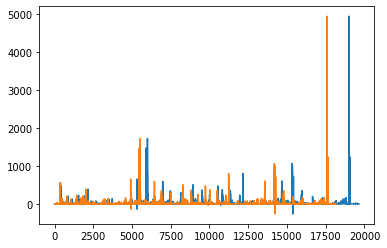

In [169]:
y.plot()
pd.Series(y_pred).plot()

In [145]:
from sklearn.neighbors import KNeighborsRegressor

In [146]:
knn = KNeighborsRegressor(n_jobs=-1)

In [148]:
%%time
knn.fit(X, y)

CPU times: user 70.5 ms, sys: 33 µs, total: 70.6 ms
Wall time: 72.1 ms


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [149]:
y_pred = knn.predict(X)
y_pred

array([0.    , 0.    , 0.    , ..., 0.1212, 0.1212, 0.1212])

In [150]:
mean_absolute_percentage_error(y, y_pred)

inf

In [151]:
root_mean_squared_error(y, y_pred)

48.84716590238327

In [152]:
X2 = X.copy()
X2['y'] = y
X2['prediction'] = y_pred

In [153]:
X2.groupby('location_code')[['y', 'prediction']]\
    .apply(lambda x: root_mean_squared_error(x['y'], x['prediction']))\
    .reset_index(drop=False)\
    .rename(columns={0: 'rmse'})\
    .merge(location_dict, on='location_code', how='inner')\
    .query('location in @countries')

location_code       rmse        location
17            17.0  11.893679         Belarus
41            41.0   0.672162           China
68            68.0  10.014005          France
73            73.0   5.732372         Germany
97            97.0   4.525406           Italy
136          136.0   4.233744     Netherlands
157          157.0   1.647042          Russia
175          175.0   0.827681     South Korea
177          177.0  11.094810           Spain
182          182.0   6.671249          Sweden
183          183.0   9.759676     Switzerland
198          198.0   6.713247  United Kingdom
199          199.0   7.729024   United States
207          207.0   0.508613           World

In [155]:
from sklearn.ensemble import RandomForestRegressor

In [156]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=13, n_jobs=-1)

In [157]:
%%time
rf.fit(X, y)

CPU times: user 2min 9s, sys: 90.9 ms, total: 2min 9s
Wall time: 11.2 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

In [158]:
y_pred = rf.predict(X)

In [159]:
mean_absolute_percentage_error(y, y_pred)

inf

In [160]:
root_mean_squared_error(y, y_pred)

24.067524896119497

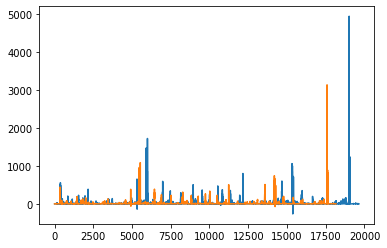

In [161]:
y.plot()
pd.Series(y_pred).plot()

In [162]:
X2 = X.copy()
X2['y'] = y
X2['prediction'] = y_pred

In [163]:
X2.groupby('location_code')[['y', 'prediction']]\
    .apply(lambda x: root_mean_squared_error(x['y'], x['prediction']))\
    .reset_index(drop=False)\
    .rename(columns={0: 'rmse'})\
    .merge(location_dict, on='location_code', how='inner')\
    .query('location in @countries')

location_code       rmse        location
17            17.0   9.698693         Belarus
41            41.0   0.768617           China
68            68.0  10.159659          France
73            73.0   6.540689         Germany
97            97.0   5.685060           Italy
136          136.0   5.494467     Netherlands
157          157.0   3.096429          Russia
175          175.0   1.344145     South Korea
177          177.0  12.613847           Spain
182          182.0   8.897820          Sweden
183          183.0  10.059244     Switzerland
198          198.0   7.324412  United Kingdom
199          199.0   8.484200   United States
207          207.0   1.207492           World